In [1]:
# Flux at spacecraft:
import numpy as np
import pickle
from build_database import flux_obj
from scipy import interpolate
from matplotlib import pyplot as plt
from GLD_file_tools import GLD_file_tools
from satellite import Satellite
import datetime
import ephem
from coordinate_structure import coordinate_structure
from coordinate_structure import transform_coords
from longitude_scaling import longitude_scaling
from ionoAbsorp import ionoAbsorp
import os
from mpl_toolkits.basemap import Basemap
from precip_model import precip_model
import itertools
from measurement_model import measurement_model
import random

%matplotlib inline

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/Users/austin/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def time_bin(time_bins, time, lon):
    '''Coarsely bin into a local time of day, with the idea that
        lightning has some hourly time dependence (i.e., rarely lightning in the morning)
    '''
#    time_bins = np.linspace(0,23,4)  # Vector of times to quantize to
    d = lon*24/360                   # Hour shift in longitude    

    # Local time, in fractional hours
    LT = time.hour + np.sign(d)*time.minute/60.0 + d
    
    # Did we loop around a day?
    if LT < 0:
        LT += 24
    if LT >= 24:
        LT -= 24

    # Quantize, return
    return find_idx_nearest_val(time_bins, LT)
    
#time_bins = np.linspace(0,24,4) - 4
#print time_bins

#print [time_bin(cur_time,l) for l in np.linspace(-180,180,10)]

def find_idx_nearest_val(array, value):
    '''Returns the index of the value in the array closest to the given value. For variable quantization!'''
    idx_sorted = np.argsort(array)
    sorted_array = np.array(array[idx_sorted])
    idx = np.searchsorted(sorted_array, value, side="left")
    if idx >= len(array):
        idx_nearest = idx_sorted[len(array)-1]
        return idx_nearest
    elif idx == 0:
        idx_nearest = idx_sorted[0]
        return idx_nearest
    else:
        if abs(value - sorted_array[idx-1]) < abs(value - sorted_array[idx]):
            idx_nearest = idx_sorted[idx-1]
            return idx_nearest
        else:
            idx_nearest = idx_sorted[idx]
            return idx_nearest

# arr = np.linspace(1,10,5)
# print arr

# print find_idx_nearest_val(arr, 7.78)

In [3]:
    GLD_root  = 'alex/array/home/Vaisala/feed_data/GLD'
    NLDN_root = 'alex/array/home/Vaisala/feed_data/NLDN'

    sat_TLE  = ["1 40378U 15003C   15293.75287141  .00010129  00000-0  48835-3 0  9990",
                "2 40378  99.1043 350.5299 0153633 201.4233 158.0516 15.09095095 39471"]

    # Satellite object:
    sat = Satellite(sat_TLE[0], sat_TLE[1],'Firebird 4')

    # Measurement object:
    f = measurement_model(database = "database_saturday.pkl", multiple_bands = True)

    # ---- Do The Thing:
    inTime = "2015-11-01T00:45:00"
    plottime = datetime.datetime.strptime(inTime,  "%Y-%m-%dT%H:%M:%S")

    sat.compute(plottime)
    sat.coords.transform_to('geomagnetic')

#     # bands is a list of energy bands to sample at (depending on database, 1 thru 8)
#     print "From banded measurement (all on):"
#     print f.get_measurement(plottime, sat.coords, mode='banded',bands=f.m.E_bands)
#     print "From single measurement:"
#     print f.get_measurement(plottime, sat.coords, mode='continuous',bands=f.m.E_bands)

(91, 181, 2)
2015-11-01 00:00:30
Starting run from  2015-11-01T00:00:00
[[-60.053489691834216, -148.78594769039327, datetime.datetime(2015, 11, 1, 0, 0), 0], 0]
[[-61.958735758548805, -149.36464052863022, datetime.datetime(2015, 11, 1, 0, 0, 30), 0], 0]
[[-63.860267919063602, -150.00496414933809, datetime.datetime(2015, 11, 1, 0, 1), 1], 60.464634568743605]
[[-65.757652446549216, -150.72117101319262, datetime.datetime(2015, 11, 1, 0, 1, 30), 1], 1.140431214512531]
[[-67.650331553129192, -151.53228746649467, datetime.datetime(2015, 11, 1, 0, 2), 1], 0.096637526212909525]
[[-69.537552296617818, -152.46422767390064, datetime.datetime(2015, 11, 1, 0, 2, 30), 1], 0.063986511511638616]
[[-71.418252689575695, -153.55317797248648, datetime.datetime(2015, 11, 1, 0, 3), 1], -0.0001]
[[-73.290913452313433, -154.85113570684643, datetime.datetime(2015, 11, 1, 0, 3, 30), 0], 0]
[[-75.153268859782713, -156.43558978335452, datetime.datetime(2015, 11, 1, 0, 4), 1], -0.0001]
[[-77.001772111505346, -158.

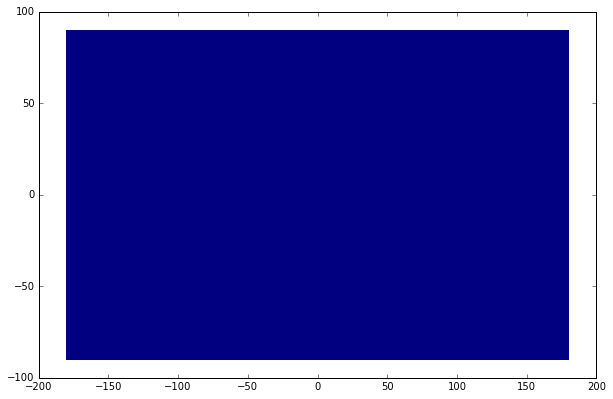

In [6]:
# State space: (Lat, Lon, Local Time, Sampling Mode)

gLats  = np.linspace(-90,90,91)
gLons  = np.linspace(-180,180,181)
gTimes = np.linspace(0,23,4)
gActs  = ['off', 'continuous']

# def lat_index(lat):
#     offset = 89
#     return int(np.round(lat) + offset)

# def lon_index(lon):
#     offset = 179
#     return int(np.round(lon) + offset)



storage_penalty = 1e-4 #1e-6  # Penalty for taking data (tunable)
alpha = 0.9
gamma = 0.1

# Simplest case -- learn a policy given lat, lon only:
Q = np.zeros([np.size(gLats), np.size(gLons), len(gActs)])
print np.shape(Q)

tStep = datetime.timedelta(seconds=30)


start_time = "2015-11-01T00:00:00"
cur_time = datetime.datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
print cur_time + tStep

sat.compute(cur_time)
geo_lon = sat.coords.lon()
sat.coords.transform_to('geomagnetic')

# Start a file to periodically dump entries to:
odb = dict()
odb['lats']    = gLats
odb['lons']    = gLons
odb['times']   = gTimes
odb['actions'] = gActs

with open('odb.pkl','wb') as file:
    pickle.dump(odb, file)


reward_table = []


# --------- Basic Q Learning routine:

print "Starting run from ", start_time
for i in range(10):


    # select an action
    action = random.choice(gActs)

    # take a measurement
    if action =='off':
        reward = 0
    else:
        meas = f.get_measurement(cur_time, sat.coords, mode=action)
        reward = meas*1e4 - storage_penalty*(action not in ['off'])
    #print reward
    #print sat.coords.lat(), sat.coords.lon()


    #cur_state = [np.int(np.round(sat.coords.lat())), np.int(np.round(sat.coords.lon())), gActs.index(action)]
    cur_ind = [find_idx_nearest_val(gLats,sat.coords.lat())[0],
                 find_idx_nearest_val(gLons,sat.coords.lon())[0],
                 time_bin(gTimes, cur_time, geo_lon),
                 gActs.index(action)]
    #print cur_ind[2]
    
#    cur_ind = [lat_index(sat.coords.lat()), lon_index(sat.coords.lon()), gActs.index(action)]
    
    #print cur_state
    #print cur_ind
#     print lat_index(sat.coords.lat())
#     print lon_index(sat.coords.lon())
    cur_state_continuous = [sat.coords.lat()[0], sat.coords.lon()[0], cur_time,  gActs.index(action)]
    
    #print cur_state
    
    # increment timestep:
    cur_time += tStep
    
    # Update satellite position for t+1:
    sat.compute(cur_time)
    geo_lon = sat.coords.lon()  # Save geographic longitude for time binning on the next iteration
    sat.coords.transform_to('geomagnetic')
    
    # Get max{a} Q(t+1,a):
    Qmax = np.max(Q[np.int(sat.coords.lat()), int(sat.coords.lon()), :], 0)
    
    # Get Q(t,a)
    
    
    Qcur = Q[cur_ind[0], cur_ind[1], cur_ind[3]]

    # update Q    
    Q[cur_ind[0], cur_ind[1], cur_ind[3]] += alpha*(reward + gamma*Qmax - Qcur)
    
    
    # Store the current state, action, and reward
    cv = [cur_state_continuous, reward]
    print cv
    reward_table.append(cv)
    
    if np.mod(i,100) == 0:
        with open('odb.pkl','wb') as file:
            pickle.dump(reward_table,file)
            reward_table = []

        plt.pcolor(gLons, gLats, Q[:,:,0])
    
    
    

IndexError: index 1 is out of bounds for axis 2 with size 1

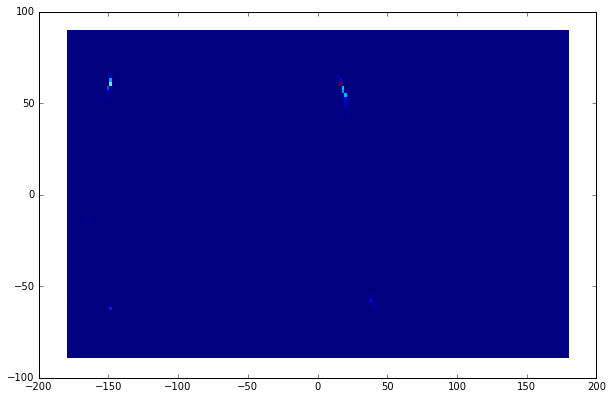

In [7]:
#print Q[cur_ind[0], cur_ind[1], cur_ind[2]]
for i in range(4):
    plt.pcolor(gLons, gLats, Q[:,:,i])

In [93]:
import numpy as np
from scipy.spatial import cKDTree as KDTree

class Invdisttree:
    """ inverse-distance-weighted interpolation using KDTree:
    invdisttree = Invdisttree( X, z )  -- points, values
    interpol = invdisttree( q, k=6, eps=0 )
        -- interpolate z from the 6 points nearest each q;
           q may be one point, or a batch of points
    """
    def __init__( self, X, z, leafsize=10 ):
        self.tree = KDTree( X, leafsize=leafsize )  # build thetree
        self.z = z

    def __call__( self, q, k=6, eps=0 ):
            # k nearest neighbours of each query point --
        self.distances, self.ix = self.tree.query( q, k=k,eps=eps )
        interpol = []  # np.zeros( (len(self.distances),) + np.shape(z[0]) )
        for dist, ix in zip( self.distances, self.ix ):
            if dist[0] > 1e-10:
                w = 1 / dist
                wz = np.dot( w, self.z[ix] ) / np.sum(w)  # weightz s by 1/dist
            else:
                wz = self.z[ix[0]]
            interpol.append( wz )
        return interpol


    
i = 0
inds = []
vals = []
for x, y in itertools.product(*[gLons, gLats]):
    inds.append(i)
    i+=1
    vals.append([x,y])


ValueError: Buffer has wrong number of dimensions (expected 2, got 1)

In [59]:
import scipy.spatial


cur_state_continuous

xv, yv = np.meshgrid(gLons, gLats)

g = np.empty([np.size(gLons), np.size(gLats)])
print np.shape(g)
for xi, x in enumerate(gLons):
    #print xi, x
    for yi, y in enumerate(gLats):
        None #print xi, yi
#        g[xi,yi] = np.array([x,y])
print g[0,:]

(181, 91)
[-180. -178. -176. -174. -172. -170. -168. -166. -164. -162. -160. -158.
 -156. -154. -152. -150. -148. -146. -144. -142. -140. -138. -136. -134.
 -132. -130. -128. -126. -124. -122. -120. -118. -116. -114. -112. -110.
 -108. -106. -104. -102. -100.  -98.  -96.  -94.  -92.  -90.  -88.  -86.
  -84.  -82.  -80.  -78.  -76.  -74.  -72.  -70.  -68.  -66.  -64.  -62.
  -60.  -58.  -56.  -54.  -52.  -50.  -48.  -46.  -44.  -42.  -40.  -38.
  -36.  -34.  -32.  -30.  -28.  -26.  -24.  -22.  -20.  -18.  -16.  -14.
  -12.  -10.   -8.   -6.   -4.   -2.    0.]


In [96]:
np.shape(Q)

fig, ax = plt.subplots(211)
for a in enumerate(ax):
    ax[a].pcolor(gLons, gLats, Q[:,:,a])

/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

KeyboardInterrupt: 